In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU

In [5]:
# Load the dataset
df = pd.read_csv('..//..//dataset//final_dataset.csv')  

# Separating features and target
X = df[['Number of Lanes', 'Status of driver', 'Nature of environment', 'Velocity of vehicle', 'Distance between vehicles', 'Breaking capability']]
y = df['Collussion']

# Normalize the features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

#skip normalization
X_scaled=X

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [6]:
print(X_train.shape, y_train.shape,X_scaled.shape)

(320000, 1, 6) (320000,) (400000, 1, 6)


# Model

In [7]:


def build_drnn_lstm():
    model = Sequential()
    
    # Add multiple SimpleRNN layers for Deep RNN
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    model.add(SimpleRNN(units=50, return_sequences=True))
    model.add(Dropout(0.1))

    # Add multiple LSTM layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))
    model.add(Dropout(0.1))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model



In [8]:
# Instantiate and train the model
model = build_drnn_lstm()
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, verbose=1)

d:\study\codes\engineering_codes\research\conda_env_for_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.9590 - loss: 0.1285 - val_accuracy: 0.9810 - val_loss: 0.0397
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9791 - loss: 0.0462 - val_accuracy: 0.9814 - val_loss: 0.0367
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9802 - loss: 0.0426 - val_accuracy: 0.9815 - val_loss: 0.0366
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9809 - loss: 0.0394 - val_accuracy: 0.9823 - val_loss: 0.0329
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9811 - loss: 0.0385 - val_accuracy: 0.9810 - val_loss: 0.0374


In [9]:
# import numpy as np

# # Set numpy to display full float numbers
# np.set_printoptions(suppress=True, precision=10)

In [10]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
# print(f'Test Accuracy: {accuracy:.2f}')

In [11]:

from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.16f}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.16f}')

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Mean Squared Error (MSE): 0.0126293618232012
Root Mean Squared Error (RMSE): 0.1123804334535206


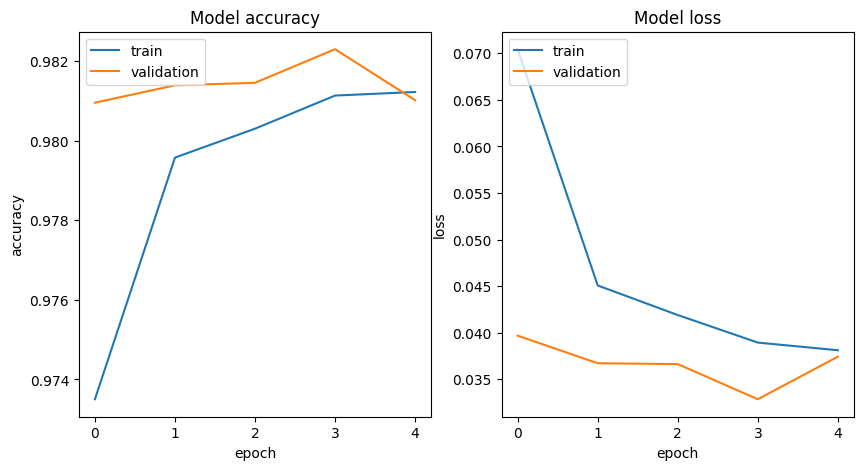

In [12]:
#visualizing the loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()


In [13]:
# model.save('..//..//models//base_paper_model.keras')  